In [1]:
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from simulate_data import simulate_data

# 初始化参数
lambda_val = 299792458 / 6.5e9  # 波长
dAntenna = 0.0204  # 天线间距
eps = np.finfo(float).eps
DeltaThetaDeg = [0, 90, 180,270]
# DeltaThetaDeg = [0, 120]

kAntennaPairCount = len(DeltaThetaDeg)

Nab = np.zeros((2, kAntennaPairCount))  # 天线向量
Nab[0, 0] = 0
Nab[1, 0] = dAntenna

kAntennaCount = Nab.shape[1]


for col in range(1, kAntennaPairCount):
    theta = DeltaThetaDeg[col] / 180 * np.pi
    Nab[:, col] = np.dot(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], Nab[:, 0]
    )

# print(kAntennaCount)
# print(Nab)


# 计算向量和等于零的组合
"zero antenna group"
Index = range(kAntennaPairCount)

for count in range(3, kAntennaPairCount):
    Choose = np.array(list(combinations(Index, count)))

    for row in range(len(Choose)):
        NabSum = np.array([0, 0])

        for col in range(len(Choose[row])):
            NabSum = NabSum + Nab[:, Choose[row][col] - 1]

        if np.all(np.abs(NabSum) < eps):
            chosen_row = Choose[row, :]

disStd = 0.05 * 1.0
phiStd = 5 * 1.0 * np.pi / 180

anchorZ = 3
AnchorPos = np.array([0, 0, anchorZ])  #基站坐标

dataSource = 0

match dataSource:
    case 0:  # 采用仿真数据
        tagZ = 1.8
        tagHeightRange = 0  # 标签在指定平面上下活动的范围
# ######   标量       标签真实轨迹   真实方位角俯仰角     相位差测量值（含噪声）   距离测量值（含噪声）
        kSampleCount, TrackTruth,    PhiThetaTruth  ,       PhiDiff,              Dis = simulate_data(
            Nab, lambda_val, AnchorPos, tagZ, disStd, phiStd
        )
    # case 1:
    #     DataTable = pd.read_excel(
    #         "data/NLink_LinkTrack_AOA_Node_Frame0_20210326_195200.xlsx"
    #     )
    #     data = DataTable.iloc[:, :]
    case _:
        print("dataSource is invalid! Check and retry.")


if dataSource != 0:
    # 若非仿真数据，需要从 table 中提取
    kSampleCount = data.shape[0]
    Dis = (data[:, 6] + data[:, 12] + data[:, 18]) / 3
    Theta = (90 + np.array([data[:, 7], data[:, 13], data[:, 19]])) * np.pi / 180
    PhiDiff = 2 * np.pi / lambda_val * dAntenna * np.cos(Theta)

print(TrackTruth.shape)
print(PhiDiff.shape)
print(Dis.shape)

(3, 1000)
(4, 1000)
(1000,)


In [2]:


# disStd = 0.1 * 0.6 * 0.01
# angleStd = 5 * 0.6 * np.pi / 180 * 0.01

TrackWithDis = np.full((3, kSampleCount), np.nan)  # PDOA+TWR
TrackWithoutDis = np.copy(TrackWithDis)  # PDOA + 固定标签高度
TrackWithDisAndFixedHeight = np.copy(TrackWithDis)  # PDOA + TWR + 固定标签高度
PhiTheta = np.full((2, kSampleCount), np.nan)  # 空间角

# 转换 aoa 角度到统一坐标 0~360
A = Nab.T
print(  A)
AAA = np.linalg.lstsq(A.T @ A, A.T, rcond=None)[0]

for index in range(kSampleCount):
    r = Dis[index]
    DeltaR = PhiDiff[:, index] * lambda_val / (2 * np.pi)
    B = A[:, 0] * AnchorPos[0] + A[:, 1] * AnchorPos[1] - r * DeltaR
    X = AAA @ B
    # FIXME 这里只是为了临时屏蔽大角度边缘区域高度计算虚数问题
    z = AnchorPos[2] - np.sqrt(
        np.abs(r**2 - (X[0] - AnchorPos[0]) ** 2 - (X[1] - AnchorPos[1]) ** 2)
    )
    TrackWithDis[:, index] = np.concatenate((X, [z]))

    # 仅根据相位差计算空间角
    B1 = -DeltaR
    X1 = AAA @ B1
    a = X1[0]
    b = X1[1]
    PhiTheta[0, index] = np.arctan2(b, a)
    sin_theta = np.sqrt(a**2 + b**2)
    sin_theta_clipped = np.clip(sin_theta, 0, 1)  # 限制在[0,1]范围内
    

    if z - AnchorPos[2] >= 0:
        PhiTheta[1, index] = np.arcsin(sin_theta_clipped)
        # PhiTheta[1, index] = np.arcsin(np.sqrt(a**2 + b**2))
    else:
        PhiTheta[1, index] = np.pi - np.arcsin(sin_theta_clipped)
        # PhiTheta[1, index] = np.pi - np.arcsin(np.sqrt(a**2 + b**2))
# 
        


    # 根据空间角及标签设定高度，基站实际高度计算位置
    dz = tagZ - anchorZ
    phi = PhiTheta[0, index]   #方向角
    theta = PhiTheta[1, index]  #俯仰角
    r1 = dz / np.cos(theta)
    TrackWithoutDis[:, index] = np.array(
        [
            AnchorPos[0] + r1 * np.sin(theta) * np.cos(phi),
            AnchorPos[1] + r1 * np.sin(theta) * np.sin(phi),
            tagZ,
        ]
    )

    # print(r)
    # print(dz)
    # 仅使用水平角+距离+固定高度计算
    # rh = np.sqrt(r**2 - dz**2)
    rh_squared = r**2 - dz**2
    rh = np.sqrt(np.maximum(rh_squared, 0))  # 确保非负
    if rh_squared < 0:
        rh = 0  # 或替换为合理小值（如 rh = np.abs(r) - np.abs(dz)）


    TrackWithDisAndFixedHeight[:, index] = np.array(
        [AnchorPos[0] + rh * np.cos(phi), AnchorPos[1] + rh * np.sin(phi), tagZ]
    )


# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), Dis, label="Dis")
# plt.legend()

[[ 0.00000000e+00  2.04000000e-02]
 [-2.04000000e-02  1.24913974e-18]
 [-2.49827947e-18 -2.04000000e-02]
 [ 2.04000000e-02 -3.74741921e-18]]


likelihood: 11.989729790637268
likelihood: 12.46397978744948
pred_prob: [0.08 0.92]
total: 12.426039787704504
[0.077191 0.922809]
likelihood: 0.27060537270258284
likelihood: 0.18759921266850382
pred_prob: [0.06157865 0.93842135]
total: 0.19271061989097651
[0.0864691 0.9135309]
likelihood: 0.00818330303769138
likelihood: 0.521353521541385
pred_prob: [0.06297036 0.93702964]
total: 0.48903900577681053
[0.03 0.97]
likelihood: 4.481570086336744
likelihood: 0.20091592558991317
pred_prob: [0.0545 0.9455]
total: 0.43421157735061544
[0.56250359 0.43749641]
likelihood: 0.10078772782056677
likelihood: 0.5177272221909325
pred_prob: [0.13437554 0.86562446]
total: 0.46170075331088867
[0.03 0.97]
likelihood: 0.18027331625302778
likelihood: 2.1114923762345392
pred_prob: [0.0545 0.9455]
total: 2.006240937465547
[0.03 0.97]
likelihood: 4.5892192936318263e-07
likelihood: 0.028100853275394414
pred_prob: [0.0545 0.9455]
total: 0.02656938178313057
[0.03 0.97]
likelihood: 0.005175972426827272
likelihood: 0.0

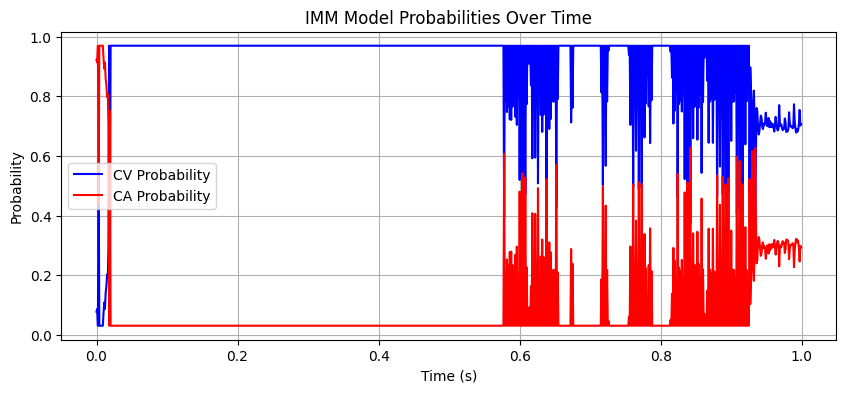

In [3]:
import numpy as np
from scipy.linalg import block_diag

# 初始状态（假设标签从原点静止启动）
x_init = np.array([5, 0, 1.8, 0, 0, 0])  # [x, y, z, vx, vy, vz]
P_init = np.diag([1, 1, 1, 1, 1, 1])  # 初始协方差

# 初始化IMM滤波器
class IMMFilter:
    def __init__(self):
        # 模型初始概率 (CV: 0.8, CA: 0.2)
        self.probs = np.array([0.2, 0.8])
        self.last_probs = None 
        
        # 转移概率矩阵 (Markov链)
        self.transition = np.array([[ 0.2,0.8],  # CV -> CV, CV -> CA
                                    [0.05, 0.95]]) # CA -> CV, CA -> CA
        
        # 创建CV和CA滤波器
        self.filters = [
            self._create_cv_filter(),
            self._create_ca_filter(sigma_a=12.0)  # 加速度噪声标准差
        ]

        self.R_phi = (phiStd ** 2) * np.eye(kAntennaCount)  # 相位差噪声
        self.R_dis = disStd ** 2                           # 距离噪声
        self.R = np.block([[self.R_phi, np.zeros((kAntennaCount, 1))],
              [np.zeros((1, kAntennaCount)), self.R_dis]])
    
    def _create_cv_filter(self):
        """创建CV模型滤波器（低过程噪声）"""
        Q = np.diag([0.01, 0.01, 0.08, 0.5, 0.5, 0.1])  # 小噪声
        return {'x': x_init.copy(), 'P': P_init.copy(), 'Q': Q}
    
    def _create_ca_filter(self, sigma_a=0.5):
        """创建CA模型滤波器（高过程噪声）"""
        # CA模型的Q矩阵构造（参见前文公式）
        dt = 1.0 / kSampleCount
        q_pos = (dt**4)/4 * sigma_a**2
        q_vel = dt**2 * sigma_a**2
        q_cross = (dt**3)/2 * sigma_a**2
        Q = np.array([
            [q_pos, 0, 0, q_cross, 0, 0],
            [0, q_pos, 0, 0, q_cross, 0],
            [0, 0, q_pos, 0, 0, q_cross],
            [q_cross, 0, 0, q_vel, 0, 0],
            [0, q_cross, 0, 0, q_vel, 0],
            [0, 0, q_cross, 0, 0, q_vel]
        ])
        return {'x': x_init.copy(), 'P': P_init.copy(), 'Q': Q}
    def get_F_matrix( self,dt):
        """CV模型基础"""
        return np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
    
    def mixing(self):
        """模型交互（Mixing）步骤"""
        # 计算混合权重（基于模型概率和转移概率）
        c = np.dot(self.transition.T, self.last_probs)
        mixing_weights = (self.transition * self.last_probs) / c[:, np.newaxis]
       
        
        # 计算混合初始状态和协方差
        mixed_states = []
        mixed_covariances = []
        for j in range(len(self.filters)):
            x_mixed = np.zeros_like(self.filters[0]['x'])
            P_mixed = np.zeros_like(self.filters[0]['P'])
            
            for i in range(len(self.filters)):
                x_mixed += mixing_weights[i, j] * self.filters[i]['x']
                # 协方差混合需考虑状态差异（P + (x_i - x_j)(x_i - x_j)^T）
                dx = self.filters[i]['x'] - x_mixed
                P_mixed += mixing_weights[i, j] * (self.filters[i]['P'] + np.outer(dx, dx))
            
            mixed_states.append(x_mixed)
            mixed_covariances.append(P_mixed)
        
        # 更新滤波器的初始状态
        for i, f in enumerate(self.filters):
            f['x'] = mixed_states[i]
            f['P'] = mixed_covariances[i]
    def predict(self, dt):
        """各模型独立预测"""
        if self.last_probs is not None:  # 非第一步时执行混合
            self.mixing()
        F = self.get_F_matrix(dt)
        for f in self.filters:
            f['x'] = F @ f['x']
            f['P'] = F @ f['P'] @ F.T + f['Q']
        self.last_probs = self.probs.copy()  # 保存当前概率供下一步使用

    def observation_model(self, x, AnchorPos, Nab, lambda_val):

        pos = x[:3]
        r = np.linalg.norm(pos - AnchorPos)
        
        vTO = AnchorPos - pos
        vTO = (AnchorPos - pos) / r  # 单位方向向量
        PhiDiff_ekf = np.zeros(Nab.shape[1])
        for i in range(Nab.shape[1]):
            vNab = np.array([Nab[0, i], Nab[1, i], 0])  # 天线对向量
            deltaR = np.dot(vTO, vNab)
            PhiDiff_ekf[i] = (2 * np.pi / lambda_val) * deltaR
        
        # 合并观测值
        z = np.concatenate([PhiDiff_ekf, [r]])
        return z
    
    def compute_H(self , x_pred, AnchorPos, Nab, lambda_val, eps=1e-6):
        """数值法计算雅可比矩阵（带防错处理）"""
        H = np.zeros((kAntennaCount + 1, 6))
        h0 = self.observation_model(x_pred, AnchorPos, Nab, lambda_val)
        
        for i in range(6):
            dx = np.zeros(6)
            dx[i] = eps
            h_eps = self.observation_model(x_pred + dx, AnchorPos, Nab, lambda_val)
            H[:, i] = (h_eps - h0) / eps

        return H
    def update(self, z, AnchorPos, Nab, lambda_val):
        """IMM更新步"""
        # 1. 各滤波器更新
        likelihoods = []
        for i, f in enumerate(self.filters):
            # 计算雅可比矩阵H
            H = self.compute_H(f['x'], AnchorPos, Nab, lambda_val)
            if np.any(np.isnan(H)):
                H = np.zeros_like(H)
                print(f"滤波器{i}雅可比异常！")
            # 计算卡尔曼增益
            S = H @ f['P'] @ H.T + self.R
            S = 0.5 * (S + S.T) + 1e-6 * np.eye(S.shape[0])  #正则化
            try:
                K = f['P'] @ H.T @ np.linalg.inv(S)
            except:
                K = np.zeros((6, S.shape[0]))
                print(f"滤波器{i}增益计算失败！")
        
            
            # 更新状态和协方差
            z_pred = self.observation_model(f['x'], AnchorPos, Nab, lambda_val)
            innovation = z - z_pred
            f['x'] = f['x'] + K @ innovation
            f['P'] = (np.eye(6) - K @ H) @ f['P']
            
            
            # 计算模型似然（多元高斯分布）
            det_S = np.linalg.det(S)
            if det_S <= 0: det_S = 1e-6  # 防错处理
            likelihood = np.exp(-0.5 * innovation.T @ np.linalg.inv(S) @ innovation) / np.sqrt((2*np.pi)**4 * det_S)
            likelihoods.append(likelihood)
            print("likelihood:",likelihood)
        
        # 2. 更新模型概率
        pred_probs = self.transition.T @ self.probs
        print("pred_prob:",pred_probs)
        total = np.dot(likelihoods, pred_probs)
        print("total:",total)
        self.probs = likelihoods * pred_probs / total
        self.probs = np.clip( self.probs, 0.03, 0.97)  # 防零概率
        self.probs /= np.sum(self.probs)  # 归一化
        
        # 3. 融合输出
        x_est = sum(p * f['x'] for p, f in zip(self.probs, self.filters))
        return x_est, innovation

# 初始化IMM
imm = IMMFilter()

# 存储结果
TrackEKF = np.full((3, kSampleCount), np.nan)
TrackEKF_residu = np.full((4, kSampleCount), np.nan)
TrackEKF_velocity = np.full((3, kSampleCount), np.nan)
ModelProbs = np.full((2, kSampleCount), np.nan)  # 存储CV/CA概率

for index in range(kSampleCount):
    dt = 1.0 / kSampleCount
    z_meas = np.concatenate([PhiDiff[:, index], [Dis[index]]])
    
    # --- IMM预测步 ---
    imm.predict(dt)
    
    # --- IMM更新步 ---
    x_est, innovation = imm.update(z_meas, AnchorPos, Nab, lambda_val)
    
    # 存储结果
    TrackEKF[:, index] = x_est[:3]
    TrackEKF_residu[:, index] = innovation[:4]
    TrackEKF_velocity[:, index] = x_est[3:6]
    ModelProbs[:, index] = imm.probs
    print(imm.probs)

t = np.arange(kSampleCount) * (1.0 / kSampleCount)  # 时间轴

plt.figure(figsize=(10, 4))
plt.plot(t, ModelProbs[0], 'b-', label='CV Probability')
plt.plot(t, ModelProbs[1], 'r-', label='CA Probability')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.title('IMM Model Probabilities Over Time')
plt.legend()
plt.grid(True)
plt.show()

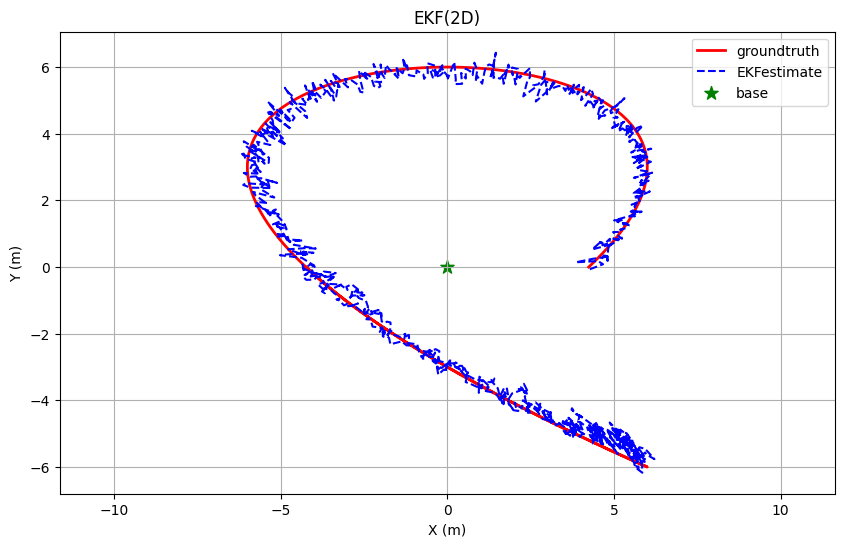

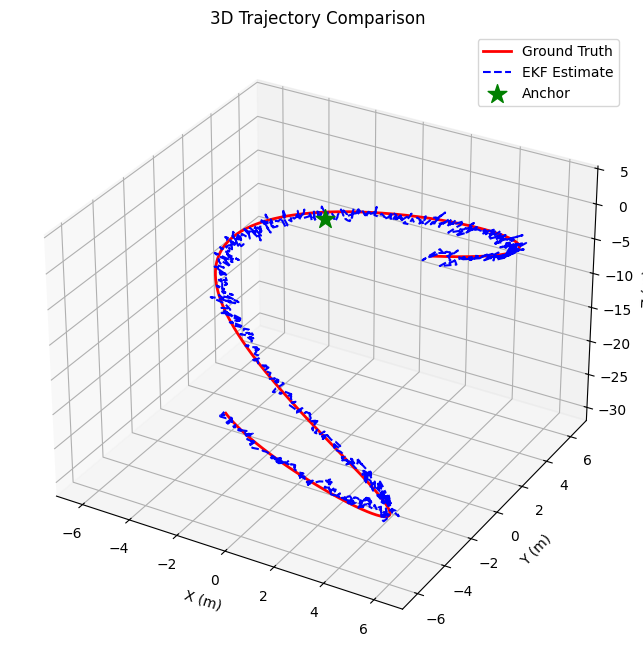

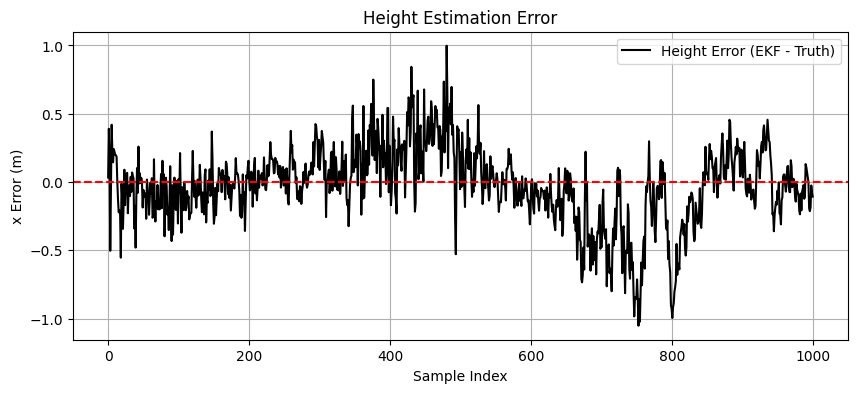

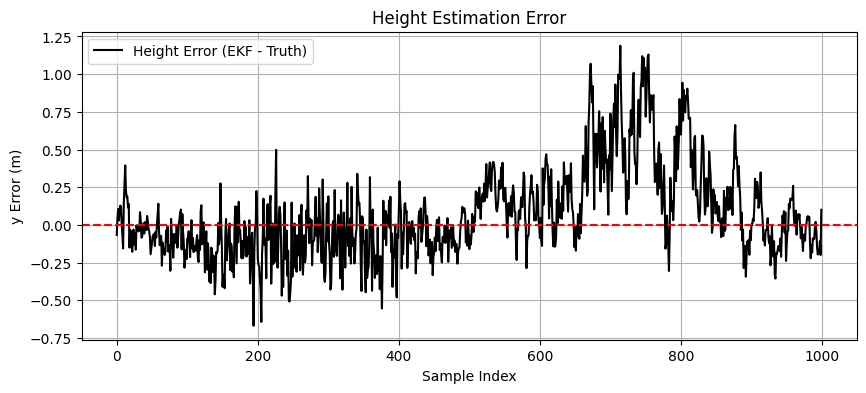

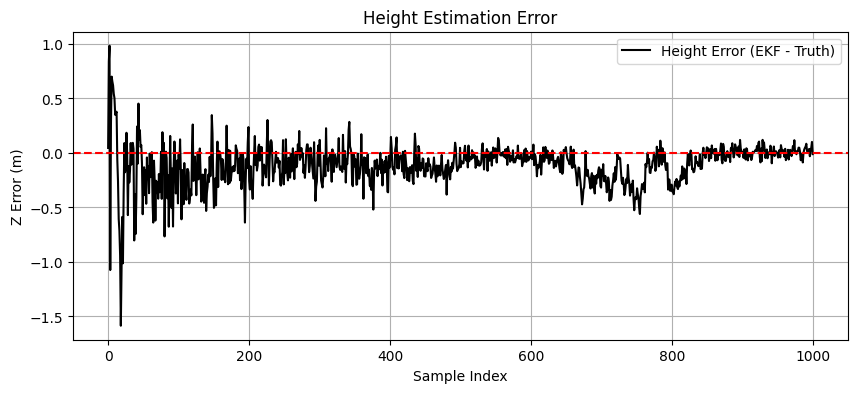

In [4]:
from mpl_toolkits.mplot3d import Axes3D
# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), TrackEKF_residu[3,:], label="Dis")
# plt.legend()

def plt1():
        plt.figure(figsize=(10, 6))
        plt.plot(TrackTruth[0], TrackTruth[1], 'r-', linewidth=2, label='groundtruth')
        plt.plot(TrackEKF[0], TrackEKF[1], 'b--', linewidth=1.5, label='EKFestimate')
        plt.scatter(AnchorPos[0], AnchorPos[1], c='green', s=100, marker='*', label='base')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('EKF(2D)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 保证x/y轴比例一致
def plt2():
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 绘制轨迹
        ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
                'r-', label='Ground Truth', linewidth=2)
        ax.plot(TrackEKF[0], TrackEKF[1], TrackEKF[2], 
                'b--', label='EKF Estimate', linewidth=1.5)
        # ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
        #         'g--', label='TrackWithDis', linewidth=1.5)

        # 绘制基站
        ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
                c='green', s=200, marker='*', label='Anchor')

        # 美化设置
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('3D Trajectory Comparison')
        ax.legend()
        ax.grid(True)
def plt3():
        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[0] - TrackTruth[0], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('x Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)


        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[1] - TrackTruth[1], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('y Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)

        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[2] - TrackTruth[2], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('Z Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)
plt1()
plt2()
plt3()